# Wasserstein GAN (WGAN)

In [1]:
from fastai.conv_learner import *
from fastai.dataset import *

## Dataset: lsun bedrooms

In [2]:
PATH = Path('data/lsun/')
IMG_PATH = PATH/'bedrooms'
CSV_PATH = PATH/'files.csv'
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)

In [3]:
TMP_PATH.mkdir(exist_ok=True)

In [4]:
files = PATH.glob('bedrooms/**/*.jpg')

In [5]:
with CSV_PATH.open('w') as out:
    for f in files:
        out.write(f'{f.relative_to(IMG_PATH)},0\n')
        
# The 0 is a fake label so that we can utilize existing dataset and dataloader objects

# Note: for experimenting its useful to create a small subset of the dataset. Simply do `if random.random()<0.1: out.write...`

In [6]:
bs=128
sz=64
nz=100

In [7]:
tfms = tfms_from_stats(inception_stats, sz)

In [8]:
modeldata = ImageClassifierData.from_csv(PATH, 'bedrooms', CSV_PATH, tfms=tfms, bs=bs, skip_header=False, continuous=True)

In [9]:
x, _ = next(iter(modeldata.val_dl))

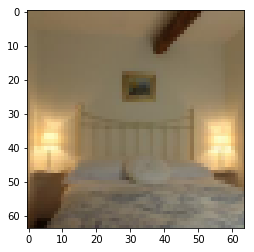

In [10]:
plt.imshow(modeldata.trn_ds.denorm(x)[6])

## Architecture

In [11]:
class ConvLayer(nn.Module):
    def __init__(self, n_in, n_out, kernel_size, stride, bn=True, pad=None):
        super().__init__()
        
        if pad is None: pad = kernel_size//2//stride
        
        self.conv = nn.Conv2d(n_in, n_out, kernel_size, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(n_out) if bn else None
        self.leakyRelu = nn.LeakyReLU(0.2, inplace=True)
    
    def forward(self, x):
        x = self.leakyRelu(self.conv(x))
        return self.bn(x) if self.bn else x

### Discriminator

Gives a single number that says whether it believes the image is real or fake

In [22]:
class Discriminator(nn.Module):
    def __init__(self, in_size, n_in, n_out, n_extra_layers=0):
        super().__init__()
        assert in_size % 16 == 0
        
        self.conv1 = ConvLayer(n_in, n_out, 4, 2, bn=False)
        csize = in_size/2
        cndf  = n_out
        
        self.extra = nn.Sequential(*[ConvLayer(cndf, cndf, 3, 1) for t in range(n_extra_layers)])  # preserve size
        
        pyramid_layers = []
        
        while csize > 4:  # until height or width is <= 4
            pyramid_layers.append(ConvLayer(cndf, cndf * 2, 4, 2))
            cndf *= 2
            csize /= 2
        
        self.pyramid = nn.Sequential(*pyramid_layers)
        self.final = nn.Conv2d(cndf, 1, 4, padding=0, bias=False)
        
    def forward(self, x):
        #pdb.set_trace()
        x = self.conv1(x)
        x = self.extra(x)
        x = self.pyramid(x) # [128, 512, 4, 4] for 64x64 input
        x = self.final(x)   # [128, 1, 1, 1] for 64x64 input, now do mean over batch
        x = x.mean(0).view(1) # torch.Size([1])
        return x

## Generator

In [27]:
class DeconvLayer(nn.Module):
    def __init__(self, n_in, n_out, kernel_size, stride, pad, bn=True):
        super().__init__()
        self.conv = nn.ConvTranspose2d(n_in, n_out, kernel_size, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(n_out) if bn else None
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x

In [ ]:
class Generator(nn.Module):
    def __init__(self, in_size, nz, n_in, n_out, n_extra_layers=0):
        super().__init__()
        assert in_size % 16 == 0
        
        

In [23]:
netD = Discriminator(sz, 3, 64, 1)